### NEURAL NETWORK LIBRARY


In [2]:
import numpy as np

class Layer:
    def __init__(self):
        pass

    def forward(self, input):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        
        limit = np.sqrt(6 / (input_dim + output_dim))
        self.weights = np.random.uniform(-limit, limit, (output_dim, input_dim))
        self.biases = np.zeros(output_dim)

        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)
        
    def forward(self, input):
        if input.shape[1] != self.input_dim:
            raise ValueError(f"Input dimension mismatch. Expected {self.input_dim}, got {input.shape[1]}")
        
        self.input = input  # Store for backward pass
        return np.dot(input, self.weights.T) + self.biases

    def backward(self, grad_output):
        # Ensure grad_output is 2D
        if grad_output.ndim == 1:
            grad_output = grad_output.reshape(-1, 1)

        grad_input = np.dot(grad_output, self.weights)
        self.grad_weights = np.dot(grad_output.T, self.input)
        self.grad_biases = np.sum(grad_output, axis=0)

        return grad_input
        
# Sigmoid activation layer
class Sigmoid(Layer):
    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def backward(self, grad_output):
        return self.output * (1 - self.output) * grad_output
    
class Tanh(Layer):
    def forward(self, input):
        self.output = np.tanh(input)
        return self.output

    def backward(self, grad_output):
        return (1 - self.output ** 2) * grad_output

    
class ReLU(Layer):
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input

class BinaryCrossEntropy(Layer):
    def forward(self, predictions, targets):
        # Avoid division by zero
        predictions = np.clip(predictions, 1e-12, 1. - 1e-12)
        # Calculate binary cross-entropy
        loss = -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))
        return loss

    def backward(self, predictions, targets):
        # Avoid division by zero
        predictions = np.clip(predictions, 1e-12, 1. - 1e-12)
        # Compute gradient of loss with respect to predictions
        grad_input = (predictions - targets) / (predictions * (1 - predictions) * predictions.shape[0])
        return grad_input



class Sequential(Layer):
    def __init__(self):
        super().__init__()
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output



def save_model(model, file_name):
    weights = {}
    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'weights'):
            weights[f'weights_{idx}'] = layer.weights
            weights[f'biases_{idx}'] = layer.biases
    np.savez(file_name, **weights)

def load_model(model, file_name):
    data = np.load(file_name)
    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'weights'):
            layer.weights = data[f'weights_{idx}']
            layer.biases = data[f'biases_{idx}']


### 1. SIGMOID ACTIVATION FUNCTION

In [3]:
import matplotlib.pyplot as plt
import numpy as np


# XOR dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0],[1],[1],[0]])

# Model definition
model = Sequential()
model.add(Linear(2, 2))
model.add(Sigmoid())
model.add(Linear(2, 1))
model.add(Sigmoid())

# Training parameters
learning_rate = 0.1
n_epochs = 10000

# Instantiate the loss layer once before the training loop
loss_layer = BinaryCrossEntropy()

# Training loop
for epoch in range(n_epochs):
    # Forward pass
    predictions = model.forward(X)
    # Compute loss
    loss = loss_layer.forward(predictions, Y)
    # Compute gradients with respect to predictions
    grad_loss = loss_layer.backward(predictions, Y)  # Corrected to pass predictions and targets
    # Backward pass through the model
    grad_input = grad_loss
    for layer in reversed(model.layers):
        if hasattr(layer, 'backward'):
            grad_input = layer.backward(grad_input)  # Ensure backward is defined and called

    # Parameters update
    for layer in model.layers:
        if isinstance(layer, Linear):
            layer.weights -= learning_rate * layer.grad_weights
            layer.biases -= learning_rate * layer.grad_biases

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# Calculate final accuracy
final_predictions = model.forward(X)
correct_predictions = np.sum((final_predictions > 0.5) == Y)
total_examples = Y.shape[0]
final_accuracy = correct_predictions / total_examples
print(f"Final Accuracy: {final_accuracy}")

# Save the model weights
save_model(model, "model2_nnxor_weights.npz")

# Load the model weights
load_model(model, "model2_nnxor_weights.npz")

Epoch 0, Loss: 0.8071524112883687
Epoch 1000, Loss: 0.6789266327900263
Epoch 2000, Loss: 0.6010824636307509
Epoch 3000, Loss: 0.47038522712502484
Epoch 4000, Loss: 0.1959639054068461
Epoch 5000, Loss: 0.07977486951972554
Epoch 6000, Loss: 0.046665783068421514
Epoch 7000, Loss: 0.03241422394211989
Epoch 8000, Loss: 0.024659267402546217
Epoch 9000, Loss: 0.01982803218806773
Final Accuracy: 1.0


### WEIGHTS & BIASES

In [4]:
def print_model_weights(model):
    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'weights'):
            print(f"Layer {idx} weights:\n", layer.weights)
            print(f"Layer {idx} biases:\n", layer.biases)

print_model_weights(model)

def print_Sigmoid_outputs(model, X):
    input = X
    for idx, layer in enumerate(model.layers):
        output = layer.forward(input)
        if isinstance(layer,Sigmoid ):
            print(f"Sigmoid layer {idx} output:\n", output)
        input = output

print_Sigmoid_outputs(model, X)

Layer 0 weights:
 [[6.56906571 6.5751495 ]
 [4.60149937 4.60253323]]
Layer 0 biases:
 [-2.8873947  -7.04025048]
Layer 2 weights:
 [[  9.70372595 -10.41352544]]
Layer 2 biases:
 [-4.44429475]
Sigmoid layer 1 output:
 [[5.27802172e-02 8.75140596e-04]
 [9.75582980e-01 8.03414159e-02]
 [9.75437639e-01 8.02650602e-02]
 [9.99964884e-01 8.96949659e-01]]
Sigmoid layer 3 output:
 [[0.01905395]
 [0.9850187 ]
 [0.98500962]
 [0.01660483]]


### DECISION BOUNDARY

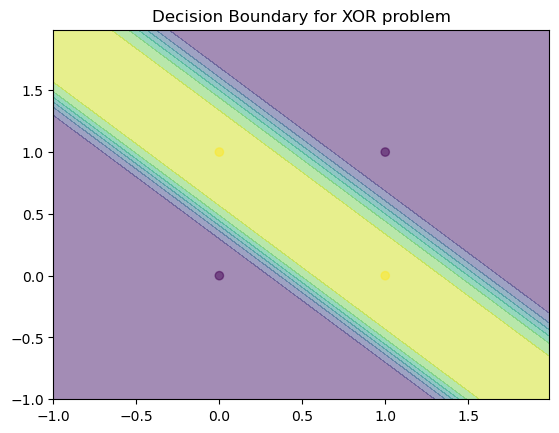

In [5]:
def plot_decision_boundary(model, X, Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=Y[:, 0], alpha=0.5)
    plt.title("Decision Boundary for XOR problem")
    plt.show()

plot_decision_boundary(model, X, Y)


### HIDDEN LAYER

Hidden layer values:
 [[-2.8873947  -7.04025048]
 [ 3.6877548  -2.43771724]
 [ 3.681671   -2.43875111]
 [10.2568205   2.16378213]]


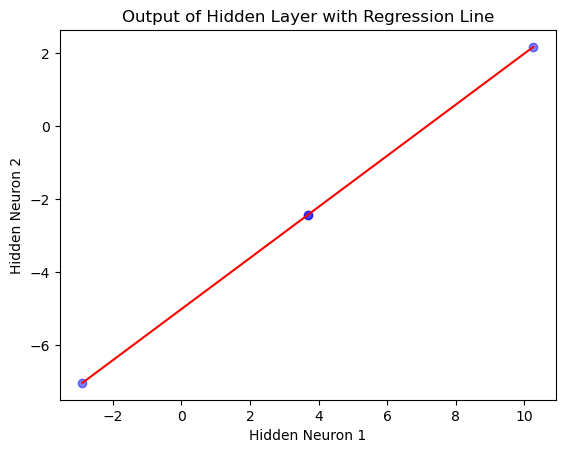

In [6]:
from sklearn.linear_model import LinearRegression

def plot_hidden_layer_with_regression(model, X):
    # Get hidden layer values
    hidden_layer_values = model.layers[0].forward(X)
    
    # Plot the hidden layer values
    plt.scatter(hidden_layer_values[:, 0], hidden_layer_values[:, 1], c='b', alpha=0.5)
    
    # Fit a linear regression line
    lr = LinearRegression()
    lr.fit(hidden_layer_values[:, 0].reshape(-1, 1), hidden_layer_values[:, 1].reshape(-1, 1))
    x_values = np.linspace(np.min(hidden_layer_values[:, 0]), np.max(hidden_layer_values[:, 0]), 100)
    y_values = lr.predict(x_values.reshape(-1, 1))

    # Get hidden layer values
    hidden_layer_values = model.layers[0].forward(X)
    
    # Print hidden layer values
    print("Hidden layer values:\n", hidden_layer_values)
    
    # Plot the linear regression line
    plt.plot(x_values, y_values, c='r')
    
    plt.title("Output of Hidden Layer with Regression Line")
    plt.xlabel("Hidden Neuron 1")
    plt.ylabel("Hidden Neuron 2")
    plt.show()

plot_hidden_layer_with_regression(model, X)


### 2.TANH FUNCTION

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# XOR dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0],[1],[1],[0]])


# Model definition
model = Sequential()
model.add(Linear(2, 2))
model.add(Tanh())  # Add Tanh activation
model.add(Linear(2, 1))
model.add(Tanh())  # Output layer with Tanh activation


# Training parameters
learning_rate = 0.1
n_epochs = 13000

# Instantiate the loss layer once before the training loop
loss_layer = BinaryCrossEntropy()

# Training loop
for epoch in range(n_epochs):
    # Forward pass
    predictions = model.forward(X)
    # Compute loss
    loss = loss_layer.forward(predictions, Y)
    # Compute gradients with respect to predictions
    grad_loss = loss_layer.backward(predictions, Y)  # Corrected to pass predictions and targets
    # Backward pass through the model
    grad_input = grad_loss
    for layer in reversed(model.layers):
        if hasattr(layer, 'backward'):
            grad_input = layer.backward(grad_input)  # Ensure backward is defined and called

    # Parameters update
    for layer in model.layers:
        if isinstance(layer, Linear):
            layer.weights -= learning_rate * layer.grad_weights
            layer.biases -= learning_rate * layer.grad_biases

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# Calculate final accuracy
final_predictions = model.forward(X)
correct_predictions = np.sum((final_predictions > 0.5) == Y)
total_examples = Y.shape[0]
final_accuracy = correct_predictions / total_examples
print(f"Final Accuracy: {final_accuracy}")

# Save the model weights
save_model(model, "model3_nnxor_weights.npz")

# Load the model weights
load_model(model, "model3_nnxor_weights.npz")

Epoch 0, Loss: 0.7880194612814513
Epoch 1000, Loss: 0.004599254127663894
Epoch 2000, Loss: 0.0018317707079696047
Epoch 3000, Loss: 0.001129437561770157
Epoch 4000, Loss: 0.0008128106366359926
Epoch 5000, Loss: 0.0006334410451012898
Epoch 6000, Loss: 0.0005182518857175114
Epoch 7000, Loss: 0.00043813938231224175
Epoch 8000, Loss: 0.0003792549212869441
Epoch 9000, Loss: 0.00033417858082036855
Epoch 10000, Loss: 0.00029858094556348006
Epoch 11000, Loss: 0.0002697677112874187
Epoch 12000, Loss: 0.0002459752956881268
Final Accuracy: 1.0


### WEIGHTS & BIASES

In [10]:
def print_model_weights(model):
    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'weights'):
            print(f"Layer {idx} weights:\n", layer.weights)
            print(f"Layer {idx} biases:\n", layer.biases)

print_model_weights(model)

def print_tanh_outputs(model, X):
    input = X
    for idx, layer in enumerate(model.layers):
        output = layer.forward(input)
        if isinstance(layer, Tanh):
            print(f"Tanh layer {idx} output:\n", output)
        input = output

print_tanh_outputs(model, X)

Layer 0 weights:
 [[ 3.41566079  3.41207601]
 [-2.44644127 -2.44565319]]
Layer 0 biases:
 [-1.6028618  3.5750369]
Layer 2 weights:
 [[4.84001841 4.96393143]]
Layer 2 biases:
 [-4.41465789]
Tanh layer 1 output:
 [[-0.9220982   0.99843162]
 [ 0.94775194  0.81080823]
 [ 0.94811552  0.81053807]
 [ 0.99994209 -0.86605032]]
Tanh layer 3 output:
 [[-0.9992153 ]
 [ 0.99954791]
 [ 0.99954829]
 [-0.99913705]]


### DECISION BOUNDARY

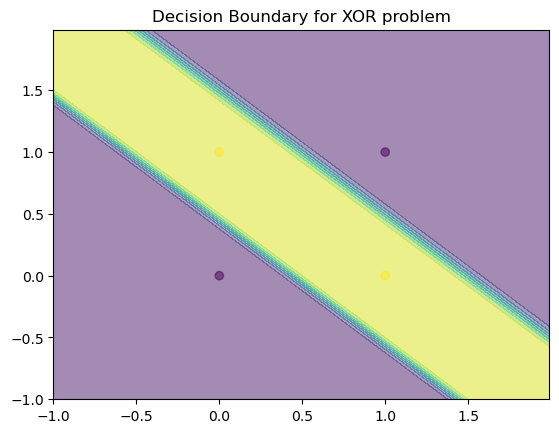

In [11]:
def plot_decision_boundary(model, X, Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=Y[:, 0], alpha=0.5)
    plt.title("Decision Boundary for XOR problem")
    plt.show()

plot_decision_boundary(model, X, Y)

### HIDDEN LAYER

Hidden layer values:
 [[-1.6028618   3.5750369 ]
 [ 1.80921421  1.12938371]
 [ 1.812799    1.12859563]
 [ 5.22487501 -1.31705757]]


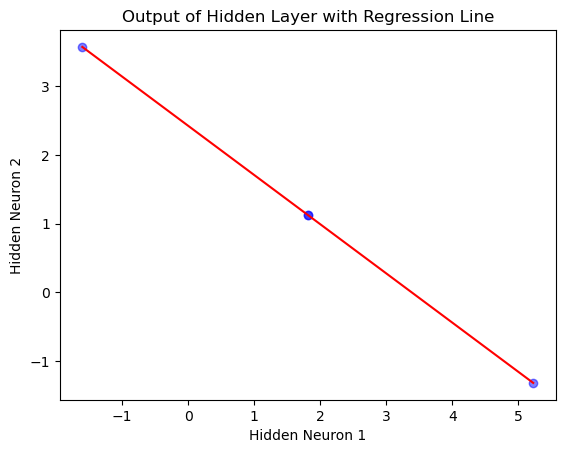

In [12]:
from sklearn.linear_model import LinearRegression

def plot_hidden_layer_with_regression(model, X):
    # Get hidden layer values
    hidden_layer_values = model.layers[0].forward(X)
    
    # Plot the hidden layer values
    plt.scatter(hidden_layer_values[:, 0], hidden_layer_values[:, 1], c='b', alpha=0.5)
    
    # Fit a linear regression line
    lr = LinearRegression()
    lr.fit(hidden_layer_values[:, 0].reshape(-1, 1), hidden_layer_values[:, 1].reshape(-1, 1))
    x_values = np.linspace(np.min(hidden_layer_values[:, 0]), np.max(hidden_layer_values[:, 0]), 100)
    y_values = lr.predict(x_values.reshape(-1, 1))

    # Get hidden layer values
    hidden_layer_values = model.layers[0].forward(X)
    
    # Print hidden layer values
    print("Hidden layer values:\n", hidden_layer_values)
    
    # Plot the linear regression line
    plt.plot(x_values, y_values, c='r')
    
    plt.title("Output of Hidden Layer with Regression Line")
    plt.xlabel("Hidden Neuron 1")
    plt.ylabel("Hidden Neuron 2")
    plt.show()

plot_hidden_layer_with_regression(model, X)
